# Data Analysis on Climate Timeseries Data-set

This is a set of climate time series in which different climate variables (i.e. temperature , windspeed, rainfall, etc) are summarized on a yearly basis. The purpose of this note book is NOT to be a teaching prototype but to crunch the numbers, derive useful relationships and visualizations in order to asses the potential in this data for the dds-notebook project.

In [13]:
import numpy as np
import scipy as s
from bokeh.browserlib import view
from bokeh.document import Document
from bokeh.embed import file_html
from bokeh.models.glyphs import Circle, Text
from bokeh.models import (
    BasicTicker, ColumnDataSource, Grid, GridPlot, LinearAxis,
    DataRange1d, PanTool, Plot, WheelZoomTool,HoverTool
)
from bokeh.resources import INLINE
from bokeh.sampledata.iris import flowers
from bokeh.plotting import *
from bokeh.io import gridplot, output_file, show, vplot
import re
from os import listdir
from os.path import isfile, join
from itertools import product
from collections import OrderedDict

##Correlaiton Plots

The following code both cleans up the data and readys it for correlation plots. Some of the code can do with refactoring but there are some relatively not neat routines required thus they can be incorporated as libraries in the misc package.
Most climate variables exihibit no obvious relationship. In the example here only 3 a plotted at a time sinc there is really not enough space to plot all 64 combinations (this includes tranpose of plots).[EDIT: Everything is currently being plotted]



###Parsing and pairing up climate vairables
The following snippet defines the pair_data function which both parses the timeseries of two variables at a time and pairs them up for a scatter plot of one vs the other. Some abstractions are urgently required in this section.


In [14]:
# Read in html tags string (the data was extracted from an interactive SEPA graph in a rather hacky manner)
# Thus the output consists of a clause of inner html tags which is actually convinient to examplify operations
# on strings within python.
path = "../../data/SPRI/climate_timeseries"
txts = [ f for f in listdir(path) if(isfile(join(path,f)) and 'txt' in f) ]


html_tags = {}
for x in txts:
    html_tags[x] = list(set(open("../../data/SPRI/climate_timeseries/"+x, 'r').read().split(">,<")))
    # ^ tags contain duplicates due to the process they were retrieved in thus we use set to remove them
# print(list(html_tags['edinburgh_tmp.txt']))
# bbbbbb
# Regex for values + filtering over the data set
def pair_data(html_tags1, html_tags2, split_by=2010):
    # Year, value parsing functions 
    year = lambda x:(int(re.search(r'(?<=Year:\s)(\d+)', x).group(0))
                     if re.search(r'(?<=Year:\s)(\d+)', x) else None)
    val = lambda x: (float(re.search(r'(?<=Value:\s)\d+\.?\d*', x).group(0))
                     if re.search(r'(?<=Value:\s)\d+\.?\d*', x) else None)

    # obtain years and values for every tag in both data sets and place them in
    # dictionary data structure since this is probably one ofthe most efficient
    # ways to pair them on later on
    first_pair = dict(zip(filter(lambda x: x is not None,
                          map(year, html_tags1)),
                         (filter(lambda x: x is not None,
                          map(val, html_tags1)))))
    #print(first_pair)
    # bbbb

    second_pair = dict(zip((filter(lambda x: x is not None,
                            map(year, html_tags2))),
                           (filter(lambda x: x is not None,
                            map(val, html_tags2)))))

    first_y = []
    second_y = []
    
    # Determine which pair is larger and pair up relative to
    # that pair in order to not miss tags
    if(len(second_pair) < len(first_pair)):
        tmp = dict(second_pair)
        second_pair = dict(first_pair)
        first_pair = dict(tmp)
        del tmp
       
    # Pairing up process taking advantage of the dictionary data structure
    for k, v in second_pair.items():
        if k in first_pair:
            first_y.append((k, first_pair[k]))
            second_y.append((k,v))
    
    # Make sure to sort by one axis
    final = list(zip(first_y, second_y))
    final.sort(key=lambda x: x[0][1])
    
    if split_by:
        first_third = []
        second_third = []
        third_third = []
        for x in final:
            # Playing with splits             
            if(x[0][0] >= split_by):
                first_third.append(x)
            elif(x[0][0] >= 1980):
                second_third.append(x)
            else:
                third_third.append(x)
                

        return (np.array(first_third)[:,0],
                np.array(first_third)[:,1],
                np.array(second_third)[:,0],
                np.array(second_third)[:,1],
                np.array(third_third)[:,0],
                np.array(third_third)[:,1],
                first_pair,
                second_pair)
            

    return (np.array(final)[:,0],
            np.array(final)[:,1],
            first_pair,
            second_pair)
 

### Grid Plots

~~This snippet generates grid plots for a range of climate variables from l, j. Not figure out how to use widgets to display files of choice. Several transformations on the data kinda make it look better but there is nothing extremely strong. Some relatively notable relationships are :~~

Has a small bug when I wrote this (regex + instead of *). After fixing the bug I can spot some faint and interesting relationships such as snow_cover and temperature; min/max/avg temperature all demonstrate closeness which points out for good results and air pressure and rainy days.


Note: make sure to implement funtional transformations via widgets and choice of climate variables to display if possible. Other things to look at are outliers in the time series and check in the news if it was a particularly snowy year or an extremely hot year in edinburgh, which helps in making assesments in how valid/useful the data is.

#### GOOD IDEA:
Color scatter plots red and blue based on a split point (i.e. being before 2000 and after) this may give a visual indicator of global warming. The same idea can be used later on in the individual time series when obtaining summary statistics. Average temperature is deffinitely higher on the current years nonethless one can read this of time series.

#### Heat Map
Replace time series with heatmaps in order to aid an easier mechanism in terms of reading high values vs year.


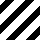
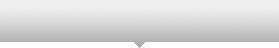
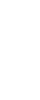
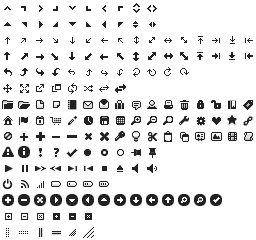
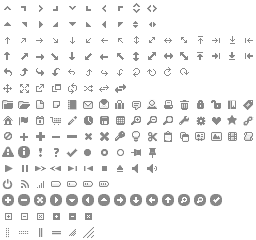
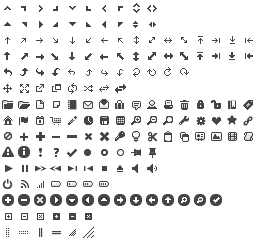
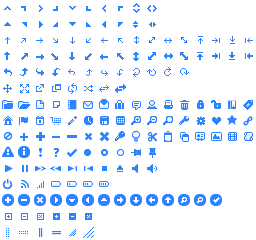
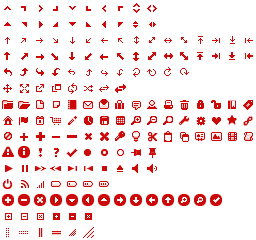
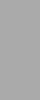
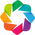
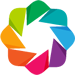
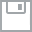
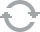
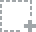
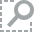
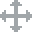
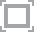
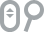

In [15]:
prod_dict = OrderedDict()
l, j = (3,6)
#print(txts)
#print(len(txts))
# txts = txts[l:j]
# COMMENT THIS LINE TO SEE ALL 64 plots
# txts = ['edinburgh_air_pressure.txt','edinburgh_sunshine.txt','edinburgh_tmp.txt']
#print(txts)
square_flag = False
for p in product(txts, repeat=2):
    if 'edinburgh_wind_speed.txt' in p:
        # print(p)
        square_flag = True
    else:
        square_flag = False
    try:
        prod_dict[str(p)] = pair_data(html_tags[p[0]],
                                      html_tags[p[1]],
                                     1995)
    except:
        pass
n = len(prod_dict)
k2 = len(txts)

fig_dict = OrderedDict()
cds_dict = OrderedDict()
for k, v in prod_dict.items():
    fig_dict[k] = figure(width=300, plot_height=300,title=str(k),
                        title_text_font_size='7pt',
                        tools="reset,hover")
    # xdata = list(np.array(v[0])[:,1]) + list(np.array(v[2])[:,1]) + list(np.array(v[4])[:,1])
    # ydata = list(np.array(v[1])[:,1]) + list(np.array(v[3])[:,1]) + list(np.array(v[5])[:,1])
    # sim = list(np.array(v[1])[:,0]) + list(np.array(v[3])[:,0]) + list(np.array(v[5])[:,0])
    cds_dict[k+'1'] = ColumnDataSource(
    data=dict(
        x=np.array(v[0])[:,1],
        y=np.array(v[1])[:,1],
        desc=np.array(v[1])[:,0]
         )
    )
    cds_dict[k+'2'] = ColumnDataSource(
    data=dict(
        x=np.array(v[2])[:,1],
        y=np.array(v[3])[:,1],
        desc2=np.array(v[3])[:,0]
         )
    )
    cds_dict[k+'3'] = ColumnDataSource(
    data=dict(
        x=np.array(v[4])[:,1],
        y=np.array(v[5])[:,1],
        desc=np.array(v[5])[:,0]
         )
    )
    hover = HoverTool()
    s1=fig_dict[k].scatter(np.array(v[0])[:,1], np.array(v[1])[:,1],fill_color='red',size=13,source=cds_dict[k +'1'])
    s1.select(dict(type=HoverTool)).tooltips = {"x":"$x", "y":"$y", "year": "$@desc"}
    s2=fig_dict[k].scatter(np.array(v[2])[:,1], np.array(v[3])[:,1],fill_color='green',size=10,source=cds_dict[k +'2'])
    s2.select(dict(type=HoverTool)).tooltips = {"x":"$x", "y":"$y", "year": "@desc"}
    s3=fig_dict[k].scatter(np.array(v[4])[:,1], np.array(v[5])[:,1],fill_color='blue',size=7,source=cds_dict[k+'3'])
    s1.select(dict(type=HoverTool)).tooltips = {"x":"$x", "y":"$y", "year": "$@desc"}
    # fig_dict[k].line(np.array(v[0])[:,1], np.array(v[1])[:,1])
    

f_vals = list(fig_dict.values())

g = gridplot([f_vals[i: i + k2] for i in range(0, n, k2)])
output_notebook()
show(g)

### Vstack Plot of all Timeseries

The following plot vertically overlays time series vertically.

In [16]:
t_fig_dict = {}
for k, v in prod_dict.items():
    t_fig_dict[k] = figure(title=k.split(",")[-1][0:-1],
                           tools=[HoverTool()])
    tmp = list(v[-1].items())
    # print(tmp)
    t_fig_dict[k].line(np.array(tmp)[:,0], np.array(tmp)[:,1])
    t_fig_dict[k].scatter(np.array(tmp)[:,0], np.array(tmp)[:,1])

v=vplot(*list(t_fig_dict.values()))
show(v)
    